# About

scatch to build the final notebook

this version uses GloVe for pre-trained embeddings

In [3]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import janitor
from time import time
import datetime

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Lambda
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Dropout
from keras.initializers import Constant
import keras.backend as K
from keras.optimizers import Adadelta
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [4]:
def prep_interim_data(p_ca_pos, p_out):
    '''
    helper function to prepare the interim dataset
    intention is to mimic the catalog data at the Employer
    we don't need much of the data, just the unspsc codes and the item names
    
    params
        p_ca_pos
            path to the data file, i.e.
            ~/data/external/ca-po/PURCHASE_ORDER_DATA_EXTRACT_2012-2015_CLEANED.zip
        p_unspsc_items
            path to the iterim data file, i.e.
            ~/data/interim/unspsc-item.csv
    '''
    t1 = pd.read_csv(p_ca_pos, dtype=str).clean_names()
    t2 = t1[["normalized_unspsc", "item_name"]]
    t3 = t2.drop_duplicates().dropna()
    t4 = t3.sort_values(by=["normalized_unspsc", "item_name"]).reset_index(drop = True)
    t4.to_csv(p_out, index = False)
    print("interim data saved to ", p_unspsc_items)
    
def sample_unspsc_item(unspsc_items, n_unspsc, n_per_unspsc, min_per_unspsc, max_per_unspsc, random_state = 0):
    '''
    helper function to sample n_per_unspsc number of examples per unspsc code,
    and n_unspsc number of codes overall
    
    params
        unspsc_items
            the data frame that contains the unspsc_items
        n_unspsc
            the number of unspsc codes we want to use in our run
        n_per_unspsc
            the number of items we want per unspsc code
            should be between min_per_unspsc and max_per_unspsc
        min_per_unspsc
            the min number of items we want per class 
        max_per_unspsc
            the max number of items we want per class
        random_state
            to set random seed, default 0
    '''
    # gets count of items per unspsc code, 
    # and filters for codes that have number of items between the min and max
    t1 = unspsc_items.groupby("normalized_unspsc").count().reset_index()
    t2 = t1.item_name.between(min_per_unspsc, max_per_unspsc, inclusive = True)
    t3 = t1[t2]
    relevant = t3
    
    # gets list of unique unspsc codes,
    # and randomly picks n_unspsc number of them for use
    t1 = relevant[["normalized_unspsc"]]
    t2 = t1.drop_duplicates()
    t3 = t2.sample(n = n_unspsc, random_state = random_state).normalized_unspsc
    uc = t3
    
    # gets only the items for the randomly picked unspsc codes
    filtered = unspsc_items[unspsc_items["normalized_unspsc"].isin(uc)]
    
    # gets a sample of items from each randomly picked unspsc code
    t1 = filtered.groupby("normalized_unspsc")
    t2 = t1.apply(lambda x: x.sample(n = n_per_unspsc, replace = False, random_state = random_state))
    t3 = t2.reset_index(drop  = True).sort_values(by = ["normalized_unspsc", "item_name"]).reset_index(drop  = True)
    t4 = t3.drop_duplicates()
    results = t4
    return(results)

def get_embeddings(p_glove):
    '''
    helper function to load GloVe embeddings
    see https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    
    params
        p_glove
            path to the GloVe embeddings, i.e.
            ~/data/external/glove/glove.6B.100d.txt
    '''
    embeddings_index = {}
    with open(p_glove) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs

    return(embeddings_index)

def prep_text_and_labels(unspsc_item):
    '''
    helper function to convert unspsc_item_samples into format usable for training
    see https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    
    params
        unspsc_item
            dataframe of unspsc_item, or some sample of unspsc_item
    '''
    texts = []  # list of text samples
    labels_index = {}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    
    texts = unspsc_item.item_name.tolist()
    label_id = 0
    for x in unspsc_item.normalized_unspsc:
        if x in labels_index.keys():
            pass
        else:
            label_id = len(labels_index)
        labels_index[x] = label_id
        labels.append(label_id)
    return(texts, labels_index, labels)

def vectorize_texts(texts, labels, n_max_words, n_padding):
    '''
    helper function to vectorize the text samples into a 2D integer tensor
    see https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    
    params
        texts
            list of texts
        labels
            list of class labels
    '''
    tokenizer = Tokenizer(num_words = n_max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print("Unique words", len(word_index))

    data = pad_sequences(sequences, maxlen = n_padding, padding = "post")

    labels_oh = to_categorical(np.asarray(labels))
    print(data.shape)
    print(labels_oh.shape)
    
    return(data, labels_oh, word_index)

def prep_embedding_matrix(word_index, embeddings_index, n_max_words, embed_dim):
    '''
    helper function to prepare the embedding matrix
    basically looks up the word in the embeddings index created earlier from GloVe
    see https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    
    params
        word_index
        embeddings_index
        n_max_words
        embed_dim
    '''
    num_words = min(n_max_words, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, embed_dim))
    for word, i in word_index.items():
        if i >= n_max_words:
            # ignores words that are more than the max number of words allowed
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    return(embedding_matrix)


In [22]:
# paths to data
p_ca_pos = os.path.join("..", "data", "external", "ca-po", "PURCHASE_ORDER_DATA_EXTRACT_2012-2015_CLEANED.zip")
p_unspsc_items = os.path.join("..", "data", "interim", "unspsc-item.csv")
p_glove = os.path.join("..", "data", "external", "glove", "glove.6B.100d.txt")

# some global params
NUM_CLASSES = 10 # number of classes we want to try for in this run
NUM_EXAMPLES_PER_CLASS = 20 # number of instances we want per class, to simulate catalog data, should be between min and max.
MIN_EXAMPLES_PER_CLASS = 20 # for picking good examples, has to be at least 4, because each class of train and validation sets must have enough examples to form pairs
MAX_EXAMPLES_PER_CLASS = 99999 # for picking good examples, should be greater than MIN_EXAMPLES_PER_CLASS

MAX_NUM_WORDS = 2000 # for vocab size
MAX_SEQUENCE_LENGTH = 1000 # for padding
VALIDATION_SPLIT = 0.5 # for train vs validation set size (this is per class split)
EMBEDDING_DIM = 100 # i.e. how wide to make the embedding. Since we are using GloVe, keep at 100

# Introduction

Inspired by problem from work. Global procurement system. Every item needs to be categorized for catalog. Item to a code. By nature of a catalog, very few items belong in each code "bucket". And there are lots of items and lots of codes, so looking for a better way to categorize items.

We don't have access to the real data from work. Instead we start with the California PO data. As part of POs, there are items and unspsc codes, which can stand in for the catalog data from work. We will need to massage the data a bit to make it resemble work data.

In [43]:
# gets and preps interim data
# We don't need all the PO data, so just stripping it down to item and unspsc codes
prep_interim_data(p_ca_pos, p_unspsc_items)

interim data saved to  ../data/interim/unspsc-item.csv


In [6]:
# gets interim data
unspsc_items = pd.read_csv(p_unspsc_items, dtype=str).clean_names()

we want to get a sample of the unspsc codes and items

even if unbalanced, to mimic catalogs, we would want only a couple of items per unspsc code

Note most unspsc codes only have a few items, which is quite similar to the real data that we don't have access to. Average items per code is 3. To make the California data reflect the real data, we need to constrain our data so that we only have a few items per unspsc code. But for the train-validate split to work, we need at least two items per code per training & validation.

median items per unspsc code 3


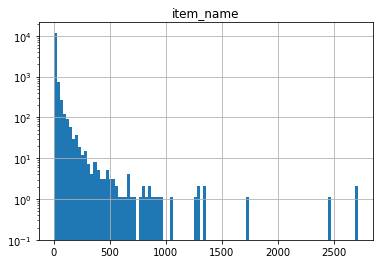

In [48]:
t1 = unspsc_items.groupby("normalized_unspsc").count()
t2 = t1.item_name.tolist()
print("median items per unspsc code", statistics.median(t2))

fig, ax = plt.subplots()
t1.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale("log")

In [23]:
# preps samples
unspsc_item_samples = sample_unspsc_item(
    unspsc_items, 
    n_unspsc = NUM_CLASSES, 
    n_per_unspsc = NUM_EXAMPLES_PER_CLASS,
    min_per_unspsc = MIN_EXAMPLES_PER_CLASS,
    max_per_unspsc = MAX_EXAMPLES_PER_CLASS, 
    random_state = 0)

print(unspsc_item_samples.shape)
print(unspsc_item_samples.groupby("normalized_unspsc").count().item_name.unique())

(200, 2)
[20]


In [24]:
# prep text and lables
texts, labels_index, labels = prep_text_and_labels(unspsc_item_samples)

# note, the labels gets converted to a one-hot class matrix, 
# so that we later we can calculate cross-entropy loss against it
data, labels_oh, word_index = vectorize_texts(texts, labels, MAX_NUM_WORDS, MAX_SEQUENCE_LENGTH)

Unique words 386
(200, 1000)
(200, 10)


In [25]:
# get embeddings
embeddings_index = get_embeddings(p_glove)
print("embeddings_index length", len(embeddings_index))

# get embedding matrix
embedding_matrix = prep_embedding_matrix(
    word_index = word_index, 
    embeddings_index = embeddings_index, 
    n_max_words = MAX_NUM_WORDS, 
    embed_dim = EMBEDDING_DIM)

print("embedding_matrix shape", embedding_matrix.shape)

# load pre-trained word embeddings into an Embedding layer
# we set trainable = False so as to keep the embeddings fixed
# because we are using the GloVe embeddings, and are not training our own embeddings
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    embeddings_initializer = Constant(embedding_matrix),
    input_length = MAX_SEQUENCE_LENGTH,
    trainable = False)

print("number of words ", num_words)
print(embedding_layer)

embeddings_index length 400000
embedding_matrix shape (387, 100)
number of words  387


# Basic CNN

* 3 convolutional layers
* 3 pooling layers
* 1 softmax layer to classify
* categorical crossentropy loss function


In [26]:
def g1(
    data, 
    labels, 
    labels_oh, 
    labels_index, 
    embedding_layer,
    split,
    seq_shape):
    '''
    1D CNN, because we're dealing with short text phrases, not images, 1D instead of 2D CNN
    
    params
        data
            matrix of vectorized text data
        labels
            array of label ids for each of the texts
        labels_oh
            one-hot matrix of labels for each of the texts
        labels_index
            dictionary of labels and ids
        embedding_layer
            the frozen embedding layer we defined with GloVe
        split
            float that represnets the validation split size
        seq_shape
            sequence length, i.e. the length with padding
    
    see https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
    see https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
    '''
    
    def split_data(data, labels, labels_oh, split, random_state = 0):
        '''
        split the data into a training set and a validation set
        note for this to simulate catalog data, we need stratified split, per class

        params
            data
                matrix of vectorized text data
            labels
                array of label ids for each of the texts
            labels_oh
                one-hot matrix of labels for each of the texts
            split
                float that represnets the validation split size
        '''
        np.random.seed(random_state)
        x_train = np.empty((0, data[0].shape[0]))
        y_train = np.empty((0, labels_oh[0].shape[0]))
        x_val = np.empty((0, data[0].shape[0]))
        y_val = np.empty((0, labels_oh[0].shape[0]))

        # gets unique classes
        uc = np.unique(labels)

        # for each class, 
        # subsets the data and labels_oh, 
        # and assigns some to train, some to validation 
        # this makes sure each class has some representation in train, and some in validation
        for c in uc:
            t1 = (labels == c)
            data_c = data[t1]
            labels_oh_c = labels_oh[t1]
            indices = np.arange(data_c.shape[0])
            np.random.shuffle(indices)
            data_c = data_c[indices]
            labels_oh_c = labels_oh_c[indices]
            num_validation_samples = int(split * data_c.shape[0])
            x_train_c = data_c[:-num_validation_samples]
            y_train_c = labels_oh_c[:-num_validation_samples]
            x_val_c = data_c[-num_validation_samples:]
            y_val_c = labels_oh_c[-num_validation_samples:]

            x_train = np.concatenate([x_train, x_train_c])
            y_train = np.concatenate([y_train, y_train_c])
            x_val = np.concatenate([x_val, x_val_c])
            y_val = np.concatenate([y_val, y_val_c])

        return(x_train, y_train, x_val, y_val)
    
    batch_size = 128
    n_epoch = 10
    learning_rate = 0.001
    
    # split the vectorized data into train and validation sets
    x_train, y_train, x_val, y_val = split_data(data, labels, labels_oh, split)
    
    # 1D CNN
    sequence_input = Input(shape = (seq_shape,), dtype = "int32")
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation = "relu")(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation = "relu")(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation = "relu")(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation = "relu")(x)
    preds = Dense(len(labels_index), activation = "softmax")(x)

    # RMSprop optimizer
    optimizer = RMSprop(lr =learning_rate)
    
    model = Model(sequence_input, preds)
    model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    
    # Start training
    training_start_time = time() # this is just for timing the runs
    
    model_trained = model.fit(x_train, y_train,
              batch_size = batch_size,
              epochs = n_epoch,
              validation_data = (x_val, y_val))
    
    print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))
    
    return(model_trained)
    
m1 = g1( data = data, 
    labels = labels, 
    labels_oh = labels_oh, 
    labels_index = labels_index, 
    embedding_layer = embedding_layer,
    split = VALIDATION_SPLIT,
    seq_shape = MAX_SEQUENCE_LENGTH)

Train on 100 samples, validate on 100 samples
Epoch 1/10
100/100 [==============================] - 3s 33ms/step - loss: 2.3055 - acc: 0.0900 - val_loss: 2.2792 - val_acc: 0.1600
Epoch 2/10
100/100 [==============================] - 3s 28ms/step - loss: 2.2446 - acc: 0.2100 - val_loss: 2.2342 - val_acc: 0.2200
Epoch 3/10
100/100 [==============================] - 3s 27ms/step - loss: 2.1361 - acc: 0.4100 - val_loss: 2.1571 - val_acc: 0.3400
Epoch 4/10
100/100 [==============================] - 3s 27ms/step - loss: 1.9780 - acc: 0.5500 - val_loss: 2.0920 - val_acc: 0.2400
Epoch 5/10
100/100 [==============================] - 3s 29ms/step - loss: 1.8157 - acc: 0.4700 - val_loss: 2.0140 - val_acc: 0.3500
Epoch 6/10
100/100 [==============================] - 3s 26ms/step - loss: 1.6665 - acc: 0.5600 - val_loss: 2.0182 - val_acc: 0.2900
Epoch 7/10
100/100 [==============================] - 3s 26ms/step - loss: 1.5636 - acc: 0.4600 - val_loss: 2.1978 - val_acc: 0.2200
Epoch 8/10
100/100 [===

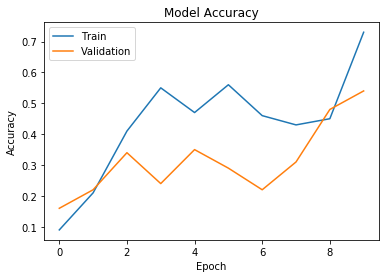

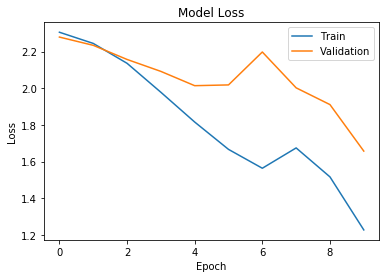

In [27]:
# Plot accuracy
plt.plot(m1.history["acc"])
plt.plot(m1.history["val_acc"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

# Plot loss
plt.plot(m1.history["loss"])
plt.plot(m1.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper right")
plt.show()

# What about siamese LSTM?

In [16]:
def g2(
    data, 
    labels, 
    embedding_layer,
    split,
    seq_shape):
    '''
    basic siamese network with LSTM
    
    params
        data
        labels
        embedding_layer
        split
        seq_shape
    
    see
    https://keras.io/examples/mnist_siamese/
    https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py
    https://sorenbouma.github.io/blog/oneshot/
    https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
    https://github.com/sorenbouma/keras-oneshot/blob/master/SiameseNet.ipynb
    
    https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07
    https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb
    https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12195/12023
    '''
    
    def split_data(data, labels, split, random_state = 0):
        '''
        split the data into a training set and a validation set
        note for this to simulate catalog data, we need stratified split, per class

        params
            data
                matrix of vectorized text data
            labels
                array of label ids for each of the texts
            labels_oh
                one-hot matrix of labels for each of the texts
            split
                float that represnets the validation split size
        '''
        np.random.seed(random_state)
        x_train = np.empty((0, data[0].shape[0]))
        y_train = np.empty((0, ))
        x_val = np.empty((0, data[0].shape[0]))
        y_val = np.empty((0, ))

        # gets unique classes
        uc = np.unique(labels)

        # for each class, 
        # subsets the data and labels, 
        # and assigns some to train, some to validation 
        # this makes sure each class has some representation in train, and some in validation
        for c in uc:
            t1 = (labels == c)
            t2 = np.array(labels)
            data_c = data[t1]
            labels_c = t2[t1]
            indices = np.arange(data_c.shape[0])
            np.random.shuffle(indices)
            data_c = data_c[indices]
            labels_c = labels_c[indices]
            num_validation_samples = int(split * data_c.shape[0])
            x_train_c = data_c[:-num_validation_samples]
            y_train_c = labels_c[:-num_validation_samples]
            x_val_c = data_c[-num_validation_samples:]
            y_val_c = labels_c[-num_validation_samples:]
            
            x_train = np.concatenate([x_train, x_train_c])
            y_train = np.concatenate([y_train, y_train_c])
            x_val = np.concatenate([x_val, x_val_c])
            y_val = np.concatenate([y_val, y_val_c])

        return(x_train, y_train, x_val, y_val)
    
    def create_pairs(x, unspsc_indices, num_classes):
        '''
        Positive and negative pair creation.
        Alternates between positive and negative pairs.

        params
            x
                either the train or validation set
            unspsc_indices
                indices of which x belongs to which class
            num_classes
                number of unique classes

        see https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py
        '''
        pairs = []
        labels = []
        n = min([len(unspsc_indices[d]) for d in range(num_classes)]) - 1
        for d in range(num_classes):
            for i in range(n):
                z1, z2 = unspsc_indices[d][i], unspsc_indices[d][i + 1]
                pairs += [[x[z1], x[z2]]]
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                z1, z2 = unspsc_indices[d][i], unspsc_indices[dn][i]
                pairs += [[x[z1], x[z2]]]
                labels += [1, 0]
        return np.array(pairs), np.array(labels)
    
    def exponent_neg_manhattan_distance(a, b):
        ''' 
        Helper function for the similarity estimate of the LSTMs outputs
        params
            a
                the "left" text
            b
                the "right" text
        '''
        return K.exp(-K.sum(K.abs(a-b), axis=1, keepdims=True))
    
    
    
    n_hidden = 10
    gradient_clipping_norm = 1.25
    batch_size = 128
    n_epoch = 5
    
    
    # split the vectorized data into train and validation sets
    x_train, y_train, x_val, y_val = split_data(data, labels, split)
    
    # gets unique classes
    num_classes = len(np.unique(labels))
    
    # creates the pairs
    unspsc_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
    tr_pairs, tr_y = create_pairs(x_train, unspsc_indices, num_classes)

    unspsc_indices = [np.where(y_val == i)[0] for i in range(num_classes)]
    vl_pairs, vl_y = create_pairs(x_val, unspsc_indices, num_classes)
    
    # network definition
    input_a = Input(shape = (seq_shape,), dtype = "int32")
    input_b = Input(shape = (seq_shape,), dtype = "int32")
    encoded_a = embedding_layer(input_a)
    encoded_b = embedding_layer(input_b)
    
    # this will be shared between a and b
    shared_lstm = LSTM(n_hidden)
    output_a = shared_lstm(encoded_a)
    output_b = shared_lstm(encoded_b)
    
    # Calculates the distance as defined by the MaLSTM model
    # see
    # https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12195/12023
    distance = Lambda(
        function = lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
        output_shape = lambda x: (x[0][0], 1)
    )([output_a, output_b])
    
    # Pack it all up into a model
    model = Model([input_a, input_b], [distance])
    
    # Adadelta optimizer, with gradient clipping by norm
#     optimizer = Adadelta(clipnorm = gradient_clipping_norm)
    optimizer = Adadelta()
    
    model.compile(loss = "mean_squared_error", optimizer = optimizer, metrics = ["accuracy"])
    
    # Start training
    training_start_time = time() # this is just for timing the runs
    
    # fit model on, 
    #    the tr_pairs 0 texts (left side) vs the tr_pairs 1 texts (right side)
    #    along with the binary labels if they are same class or not tr_y
    # validate model on,
    #    the vl_pairs 0 texts (left side) vs the vl_pairs 1 texts (right side)
    #    and their true binary labels if they are same class or not vl_y
    
    print("---------------------")
    print(vl_pairs[0])
    print("---------------------")
    print(vl_pairs[0][0])
    print("---------------------")
    print(vl_pairs[0][1])
    
#     model_trained = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
#           batch_size = batch_size,
#           epochs = n_epoch,
#           validation_data = ([vl_pairs[:, 0], vl_pairs[:, 1]], vl_y))
    
#     print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))
    
#     return(model_trained)

m2 = g2( data = data, 
    labels = labels, 
    embedding_layer = embedding_layer,
    split = VALIDATION_SPLIT,
    seq_shape = MAX_SEQUENCE_LENGTH)

---------------------
[[109. 110.  16. ...   0.   0.   0.]
 [ 12.   0.   0. ...   0.   0.   0.]]
---------------------
[109. 110.  16. 111. 112.  16. 113.  12.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0

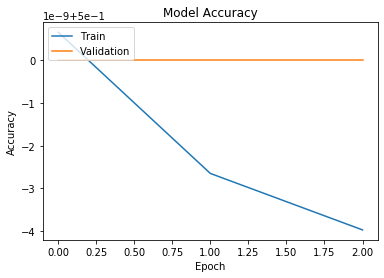

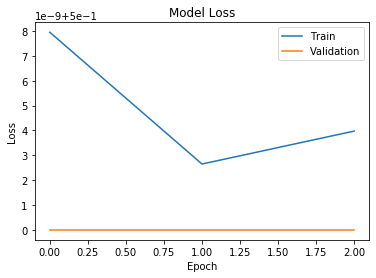

In [19]:
# Plot accuracy
plt.plot(m2.history["acc"])
plt.plot(m2.history["val_acc"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

# Plot loss
plt.plot(m2.history["loss"])
plt.plot(m2.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper right")
plt.show()

# simanese LSTM, but using euclidean distance and contrastive loss?

In [33]:
def g3(
    data, 
    labels, 
    embedding_layer,
    split,
    seq_shape):
    '''
    basic siamese network with LSTM
    
    params
        data
        labels
        embedding_layer
        split
        seq_shape
    
    see
    https://keras.io/examples/mnist_siamese/
    https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py
    https://sorenbouma.github.io/blog/oneshot/
    https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
    https://github.com/sorenbouma/keras-oneshot/blob/master/SiameseNet.ipynb
    
    https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07
    https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb
    https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12195/12023
    '''
    
    def split_data(data, labels, split, random_state = 0):
        '''
        split the data into a training set and a validation set
        note for this to simulate catalog data, we need stratified split, per class

        params
            data
                matrix of vectorized text data
            labels
                array of label ids for each of the texts
            labels_oh
                one-hot matrix of labels for each of the texts
            split
                float that represnets the validation split size
        '''
        np.random.seed(random_state)
        x_train = np.empty((0, data[0].shape[0]))
        y_train = np.empty((0, ))
        x_val = np.empty((0, data[0].shape[0]))
        y_val = np.empty((0, ))

        # gets unique classes
        uc = np.unique(labels)

        # for each class, 
        # subsets the data and labels, 
        # and assigns some to train, some to validation 
        # this makes sure each class has some representation in train, and some in validation
        for c in uc:
            t1 = (labels == c)
            t2 = np.array(labels)
            data_c = data[t1]
            labels_c = t2[t1]
            indices = np.arange(data_c.shape[0])
            np.random.shuffle(indices)
            data_c = data_c[indices]
            labels_c = labels_c[indices]
            num_validation_samples = int(split * data_c.shape[0])
            x_train_c = data_c[:-num_validation_samples]
            y_train_c = labels_c[:-num_validation_samples]
            x_val_c = data_c[-num_validation_samples:]
            y_val_c = labels_c[-num_validation_samples:]
            
            x_train = np.concatenate([x_train, x_train_c])
            y_train = np.concatenate([y_train, y_train_c])
            x_val = np.concatenate([x_val, x_val_c])
            y_val = np.concatenate([y_val, y_val_c])

        return(x_train, y_train, x_val, y_val)
    
    def create_pairs(x, unspsc_indices, num_classes):
        '''
        Positive and negative pair creation.
        Alternates between positive and negative pairs.

        params
            x
                either the train or validation set
            unspsc_indices
                indices of which x belongs to which class
            num_classes
                number of unique classes

        see https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py
        '''
        pairs = []
        labels = []
        n = min([len(unspsc_indices[d]) for d in range(num_classes)]) - 1
        for d in range(num_classes):
            for i in range(n):
                z1, z2 = unspsc_indices[d][i], unspsc_indices[d][i + 1]
                pairs += [[x[z1], x[z2]]]
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                z1, z2 = unspsc_indices[d][i], unspsc_indices[dn][i]
                pairs += [[x[z1], x[z2]]]
                labels += [1, 0]
        return np.array(pairs), np.array(labels)
    
    def euclidean_distance(vects):
        x, y = vects
        sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_square, K.epsilon()))
    
    def eucl_dist_output_shape(shapes):
        shape1, shape2 = shapes
        return (shape1[0], 1)
    
    def contrastive_loss(y_true, y_pred):
        '''
        Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        margin = 1
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    
    
    n_hidden = 10
    gradient_clipping_norm = 1.25
    batch_size = 128
    n_epoch = 5
    learning_rate = 0.001
    
    # split the vectorized data into train and validation sets
    x_train, y_train, x_val, y_val = split_data(data, labels, split)
    
    # gets unique classes
    num_classes = len(np.unique(labels))
    
    # creates the pairs
    unspsc_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
    tr_pairs, tr_y = create_pairs(x_train, unspsc_indices, num_classes)

    unspsc_indices = [np.where(y_val == i)[0] for i in range(num_classes)]
    vl_pairs, vl_y = create_pairs(x_val, unspsc_indices, num_classes)
    
    # network definition
    input_a = Input(shape = (seq_shape,), dtype = "int32")
    input_b = Input(shape = (seq_shape,), dtype = "int32")
    encoded_a = embedding_layer(input_a)
    encoded_b = embedding_layer(input_b)
    
    # this will be shared between a and b
    shared_lstm = LSTM(n_hidden)
    output_a = shared_lstm(encoded_a)
    output_b = shared_lstm(encoded_b)
    
    # Euclidean distance
    distance = Lambda(euclidean_distance, output_shape = eucl_dist_output_shape)([output_a, output_b])
    
    # Pack it all up into a model
    model = Model([input_a, input_b], [distance])
    
    # RMSprop optimizer
    optimizer = RMSprop(lr = learning_rate)
    
    model.compile(loss = contrastive_loss, optimizer = optimizer, metrics = ["accuracy"])
    
    # Start training
    training_start_time = time() # this is just for timing the runs
    
    # fit model on, 
    #    the tr_pairs 0 texts (left side) vs the tr_pairs 1 texts (right side)
    #    along with the binary labels if they are same class or not tr_y
    # validate model on,
    #    the vl_pairs 0 texts (left side) vs the vl_pairs 1 texts (right side)
    #    and their true binary labels if they are same class or not vl_y
    model_trained = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size = batch_size,
          epochs = n_epoch,
          validation_data = ([vl_pairs[:, 0], vl_pairs[:, 1]], vl_y))
    
    print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))
    
    return(model_trained)

m3 = g3( data = data, 
    labels = labels, 
    embedding_layer = embedding_layer,
    split = VALIDATION_SPLIT,
    seq_shape = MAX_SEQUENCE_LENGTH)

Train on 180 samples, validate on 180 samples
Epoch 1/10
180/180 [==============================] - 8s 42ms/step - loss: 0.4997 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 2/10
180/180 [==============================] - 4s 23ms/step - loss: 0.4997 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 3/10
180/180 [==============================] - 4s 22ms/step - loss: 0.4997 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 4/10
180/180 [==============================] - 4s 22ms/step - loss: 0.4997 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 5/10
180/180 [==============================] - 4s 23ms/step - loss: 0.4997 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 6/10
180/180 [==============================] - 4s 23ms/step - loss: 0.4997 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 7/10
180/180 [==============================] - 4s 23ms/step - loss: 0.4997 - acc: 0.5000 - val_loss: 0.4997 - val_acc: 0.5000
Epoch 8/10
180/180 [===

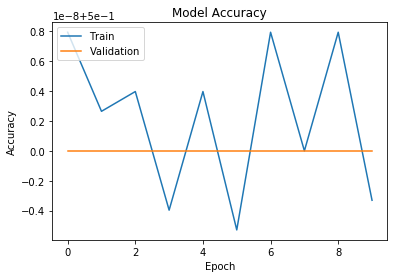

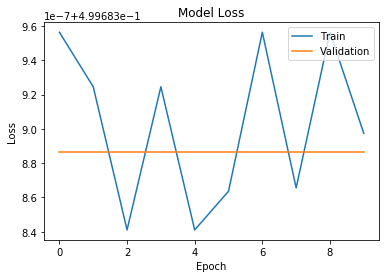

In [32]:
# Plot accuracy
plt.plot(m3.history["acc"])
plt.plot(m3.history["val_acc"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()

# Plot loss
plt.plot(m3.history["loss"])
plt.plot(m3.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc = "upper right")
plt.show()

# Simple siamese?

In [40]:
def g4(
    data, 
    labels, 
    embedding_layer,
    split,
    seq_shape):
    '''
    basic siamese network with LSTM
    
    params
        data
        labels
        embedding_layer
        split
        seq_shape
    
    see
    https://keras.io/examples/mnist_siamese/
    https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py
    https://sorenbouma.github.io/blog/oneshot/
    https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
    https://github.com/sorenbouma/keras-oneshot/blob/master/SiameseNet.ipynb
    
    https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07
    https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb
    https://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12195/12023
    '''
    
    def split_data(data, labels, split, random_state = 0):
        '''
        split the data into a training set and a validation set
        note for this to simulate catalog data, we need stratified split, per class

        params
            data
                matrix of vectorized text data
            labels
                array of label ids for each of the texts
            labels_oh
                one-hot matrix of labels for each of the texts
            split
                float that represnets the validation split size
        '''
        np.random.seed(random_state)
        x_train = np.empty((0, data[0].shape[0]))
        y_train = np.empty((0, ))
        x_val = np.empty((0, data[0].shape[0]))
        y_val = np.empty((0, ))

        # gets unique classes
        uc = np.unique(labels)

        # for each class, 
        # subsets the data and labels, 
        # and assigns some to train, some to validation 
        # this makes sure each class has some representation in train, and some in validation
        for c in uc:
            t1 = (labels == c)
            t2 = np.array(labels)
            data_c = data[t1]
            labels_c = t2[t1]
            indices = np.arange(data_c.shape[0])
            np.random.shuffle(indices)
            data_c = data_c[indices]
            labels_c = labels_c[indices]
            num_validation_samples = int(split * data_c.shape[0])
            x_train_c = data_c[:-num_validation_samples]
            y_train_c = labels_c[:-num_validation_samples]
            x_val_c = data_c[-num_validation_samples:]
            y_val_c = labels_c[-num_validation_samples:]
            
            x_train = np.concatenate([x_train, x_train_c])
            y_train = np.concatenate([y_train, y_train_c])
            x_val = np.concatenate([x_val, x_val_c])
            y_val = np.concatenate([y_val, y_val_c])

        return(x_train, y_train, x_val, y_val)
    
    def create_pairs(x, unspsc_indices, num_classes):
        '''
        Positive and negative pair creation.
        Alternates between positive and negative pairs.

        params
            x
                either the train or validation set
            unspsc_indices
                indices of which x belongs to which class
            num_classes
                number of unique classes

        see https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py
        '''
        pairs = []
        labels = []
        n = min([len(unspsc_indices[d]) for d in range(num_classes)]) - 1
        for d in range(num_classes):
            for i in range(n):
                z1, z2 = unspsc_indices[d][i], unspsc_indices[d][i + 1]
                pairs += [[x[z1], x[z2]]]
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                z1, z2 = unspsc_indices[d][i], unspsc_indices[dn][i]
                pairs += [[x[z1], x[z2]]]
                labels += [1, 0]
        return np.array(pairs), np.array(labels)
    
    def create_base_network(seq_shape):
        '''
        Base network to be shared (eq. to feature extraction).
        '''
        input = Input(shape = (seq_shape,), dtype = "int32")
        x = Flatten()(input)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(128, activation='relu')(x)
        
        return Model(input, x)
    
    def euclidean_distance(vects):
        x, y = vects
        sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_square, K.epsilon()))
    
    def eucl_dist_output_shape(shapes):
        shape1, shape2 = shapes
        return (shape1[0], 1)
    
    def contrastive_loss(y_true, y_pred):
        '''
        Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        margin = 1
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    
    
    n_hidden = 10
    gradient_clipping_norm = 1.25
    batch_size = 128
    n_epoch = 5
    learning_rate = 0.001
    
    # split the vectorized data into train and validation sets
    x_train, y_train, x_val, y_val = split_data(data, labels, split)
    
    # gets unique classes
    num_classes = len(np.unique(labels))
    
    # creates the pairs
    unspsc_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
    tr_pairs, tr_y = create_pairs(x_train, unspsc_indices, num_classes)

    unspsc_indices = [np.where(y_val == i)[0] for i in range(num_classes)]
    vl_pairs, vl_y = create_pairs(x_val, unspsc_indices, num_classes)
    
    # network definition
    # ... shared between the a (left) and b (right) branches of the network
    base_network = create_base_network(seq_shape)
    
    input_a = Input(shape = (seq_shape,), dtype = "int32")
    input_b = Input(shape = (seq_shape,), dtype = "int32")
    encoded_a = embedding_layer(input_a)
    encoded_b = embedding_layer(input_b)
    output_a = base_network(encoded_a)
    output_b = base_network(encoded_b)
    
    # Euclidean distance
    distance = Lambda(euclidean_distance, output_shape = eucl_dist_output_shape)([output_a, output_b])
    
    # Pack it all up into a model
    model = Model([encoded_a, encoded_b], [distance])
    
    # RMSprop optimizer
    optimizer = RMSprop(lr = learning_rate)
    
    model.compile(loss = contrastive_loss, optimizer = optimizer, metrics = ["accuracy"])
    
    # Start training
    training_start_time = time() # this is just for timing the runs
    
    # fit model on, 
    #    the tr_pairs 0 texts (left side) vs the tr_pairs 1 texts (right side)
    #    along with the binary labels if they are same class or not tr_y
    # validate model on,
    #    the vl_pairs 0 texts (left side) vs the vl_pairs 1 texts (right side)
    #    and their true binary labels if they are same class or not vl_y
    model_trained = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size = batch_size,
          epochs = n_epoch,
          validation_data = ([vl_pairs[:, 0], vl_pairs[:, 1]], vl_y))
    
    print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))
    
    return(model_trained)

m4 = g4( data = data, 
    labels = labels, 
    embedding_layer = embedding_layer,
    split = VALIDATION_SPLIT,
    seq_shape = MAX_SEQUENCE_LENGTH)

ValueError: Input 0 is incompatible with layer flatten_10: expected min_ndim=3, found ndim=2

# Limitations & Future Work

Use character level embeddings. GloVe works better at sentences, with real words. But item names or descriptions not necessarily actual sentences.

GloVe assumes standard english words, but certain items names might not have standard tokens.

This is vulnerable to items being thrown into the most permissive category. Will tend to select for those categories since they will have the most item names. Less appetizing for business use, since often the business aim of categorization exercises is to build a better balanced categorization that is more expressive and can be used for downstream analytics. Maybe this approach can be complemented by negatively weighing the more popular categories.
